<a href="https://colab.research.google.com/github/Prprprpprprprprppr/Dopeity-Projecty/blob/main/StudentMigrationAndSalaryPredictionAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries and suppress warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib
matplotlib.use('Agg')  # Set backend for matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

sns.set(style="whitegrid")

In [3]:
data_path = '/content/global_student_migration.csv'
df = pd.read_csv(data_path, encoding='UTF-8-SIG', delimiter=',')

# Basic inspection of dataframe
print('Data dimensions:', df.shape)
print('Columns:', df.columns.tolist())
print('Data types:', df.dtypes.to_dict())

# In case any date columns are present but not inferred, we would parse them. However, our dataset does not include explicit date columns.

Data dimensions: (5000, 20)
Columns: ['student_id', 'origin_country', 'destination_country', 'destination_city', 'university_name', 'course_name', 'field_of_study', 'year_of_enrollment', 'scholarship_received', 'enrollment_reason', 'graduation_year', 'placement_status', 'placement_country', 'placement_company', 'starting_salary_usd', 'gpa_or_score', 'visa_status', 'post_graduation_visa', 'language_proficiency_test', 'test_score']
Data types: {'student_id': dtype('O'), 'origin_country': dtype('O'), 'destination_country': dtype('O'), 'destination_city': dtype('O'), 'university_name': dtype('O'), 'course_name': dtype('O'), 'field_of_study': dtype('O'), 'year_of_enrollment': dtype('int64'), 'scholarship_received': dtype('O'), 'enrollment_reason': dtype('O'), 'graduation_year': dtype('int64'), 'placement_status': dtype('O'), 'placement_country': dtype('O'), 'placement_company': dtype('O'), 'starting_salary_usd': dtype('int64'), 'gpa_or_score': dtype('float64'), 'visa_status': dtype('O'), 'p

In [4]:
missing_values = df.isnull().sum()
print('Missing values per column:')
print(missing_values)

# If there are missing values in numeric columns that will be used in modeling, we fill them with median values
numeric_cols = ['year_of_enrollment', 'graduation_year', 'starting_salary_usd', 'gpa_or_score', 'test_score']
for col in numeric_cols:
    if col in df.columns:
        df[col].fillna(df[col].median(), inplace=True)

# For categorical columns, fill missing values with mode
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Quick look at the cleaned dataset
print('\nCleaned DataFrame Info:')
print(df.info())

Missing values per column:
student_id                      0
origin_country                  0
destination_country             0
destination_city                0
university_name                 0
course_name                     0
field_of_study                  0
year_of_enrollment              0
scholarship_received            0
enrollment_reason               0
graduation_year                 0
placement_status                0
placement_country            2491
placement_company            2491
starting_salary_usd             0
gpa_or_score                    0
visa_status                     0
post_graduation_visa            0
language_proficiency_test     982
test_score                      0
dtype: int64

Cleaned DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   student_id                 5000

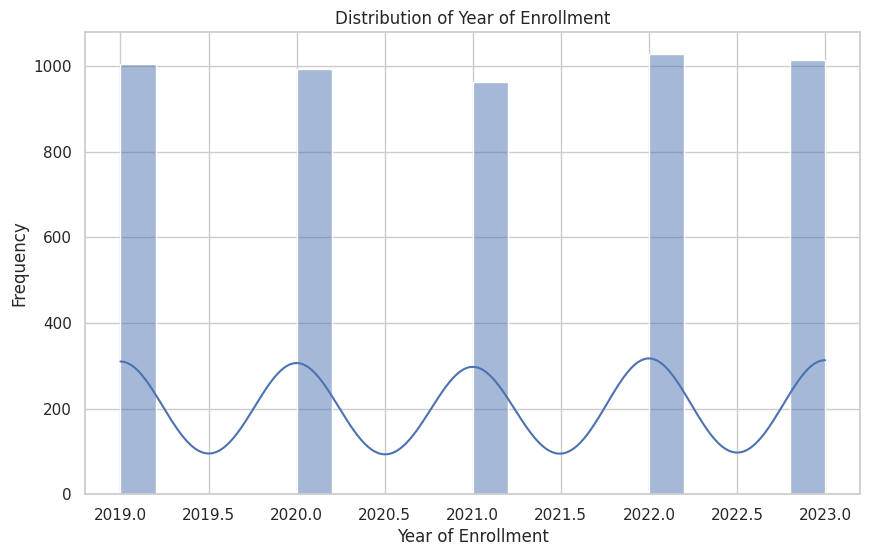

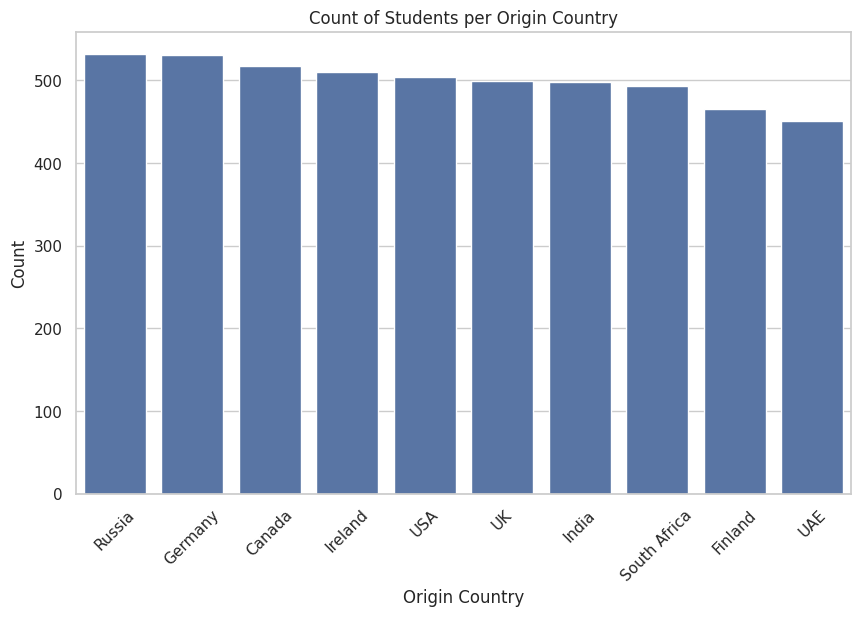

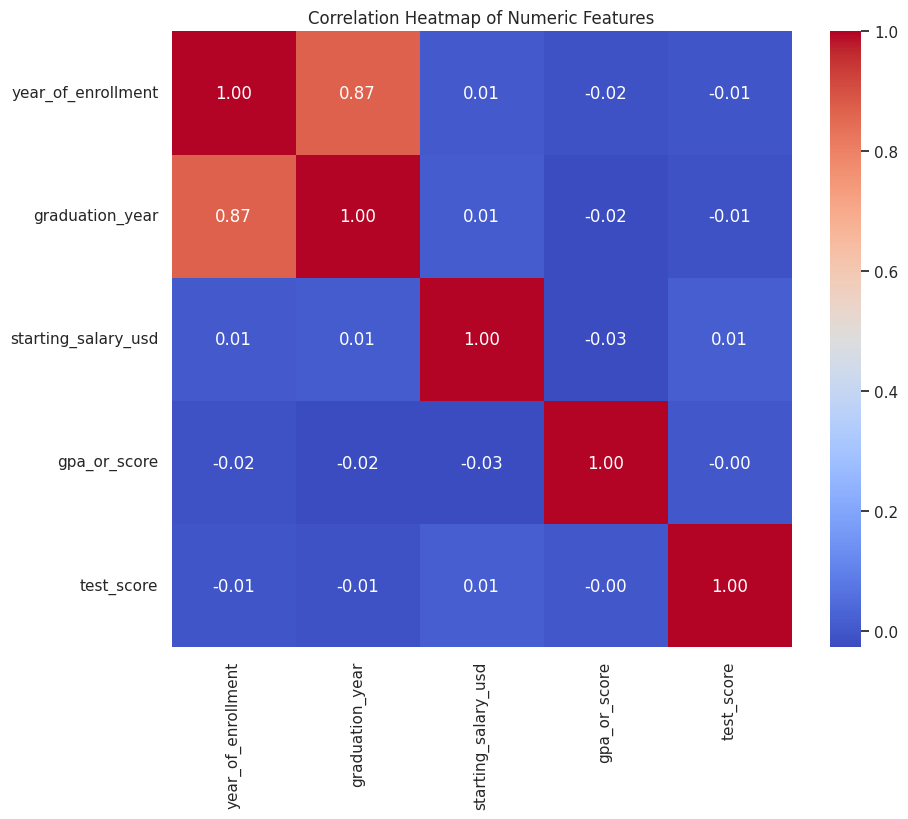

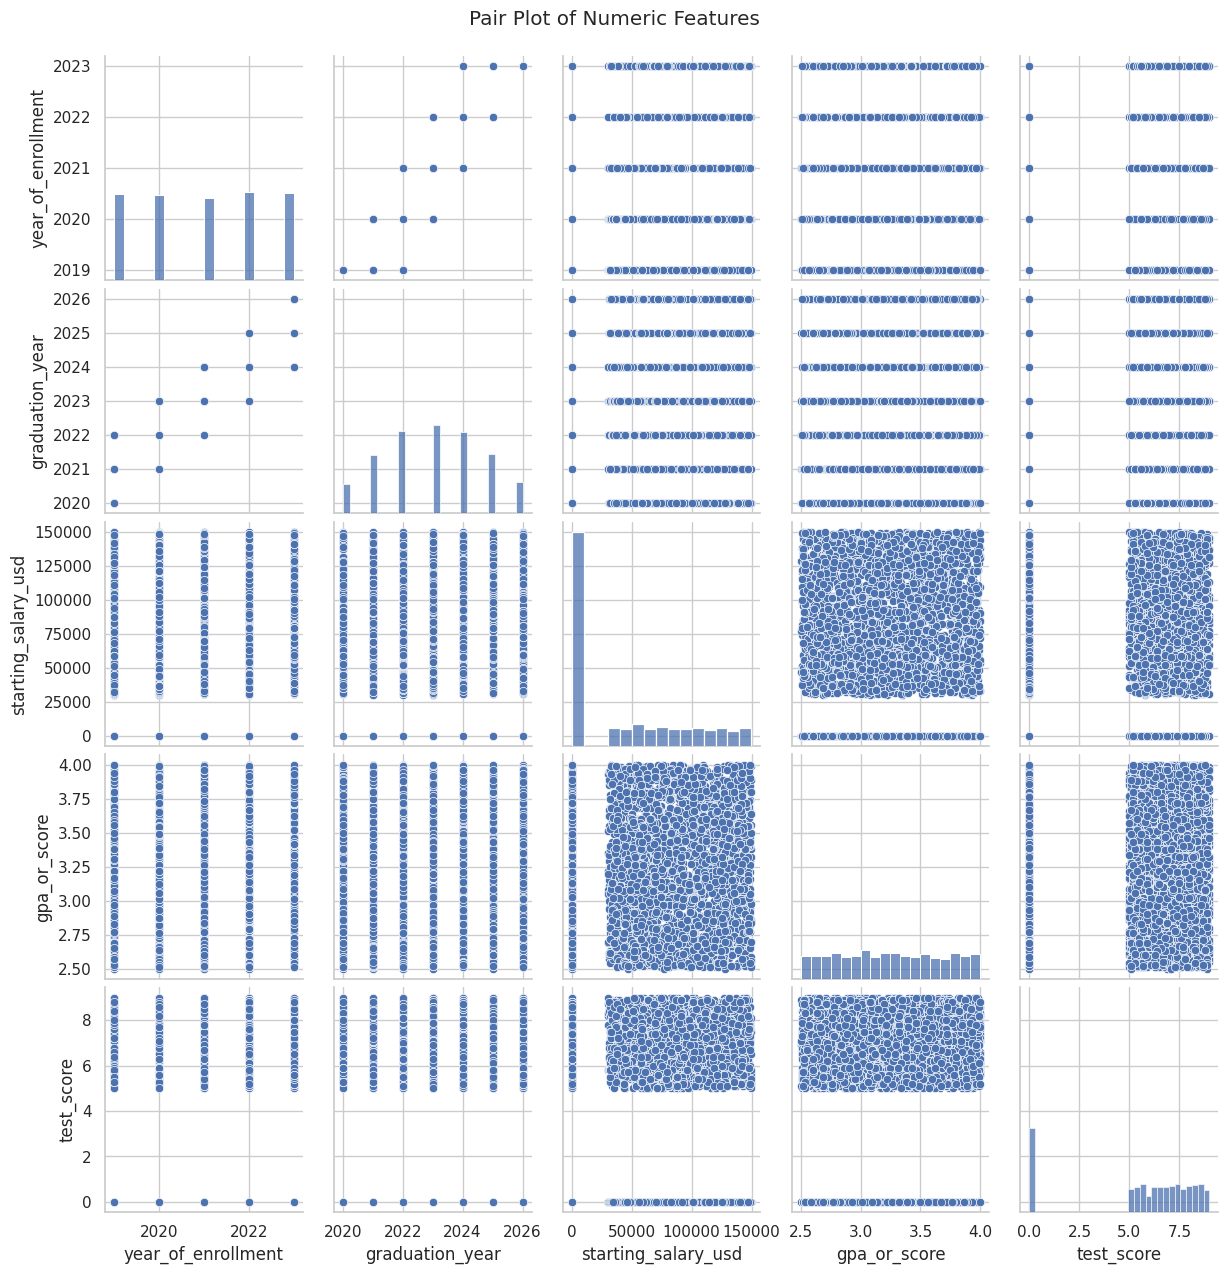

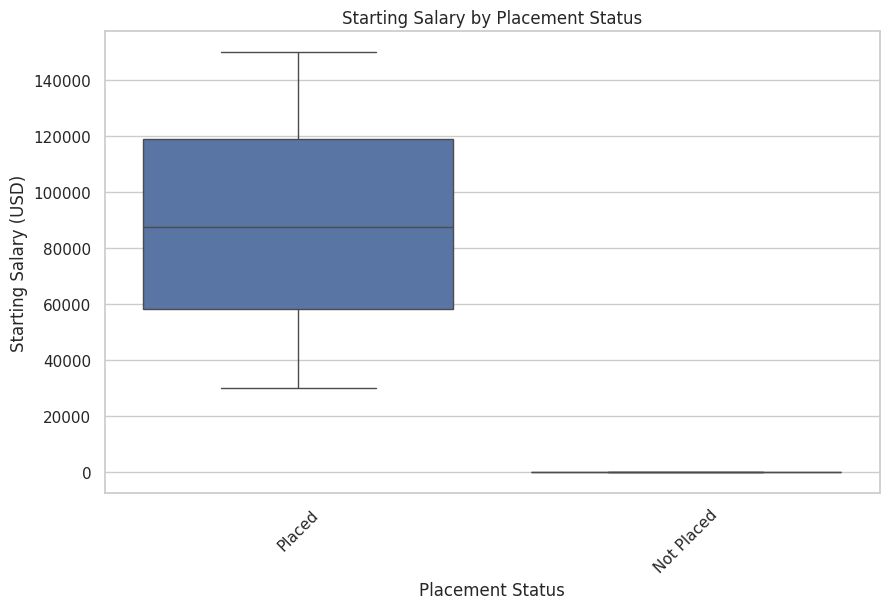

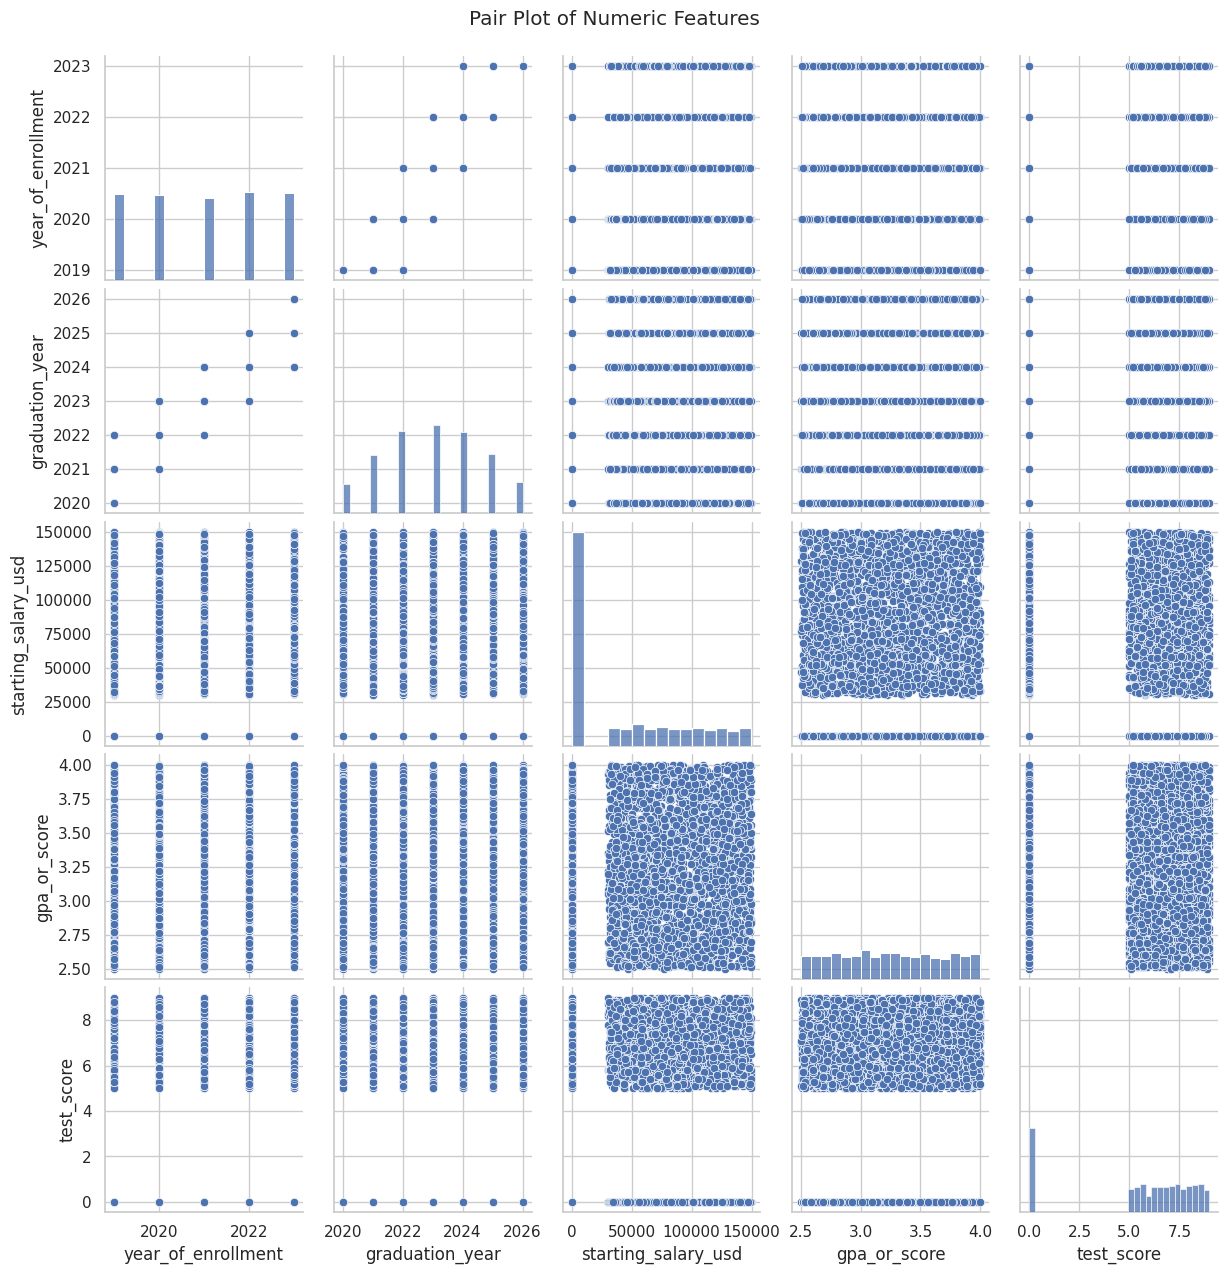

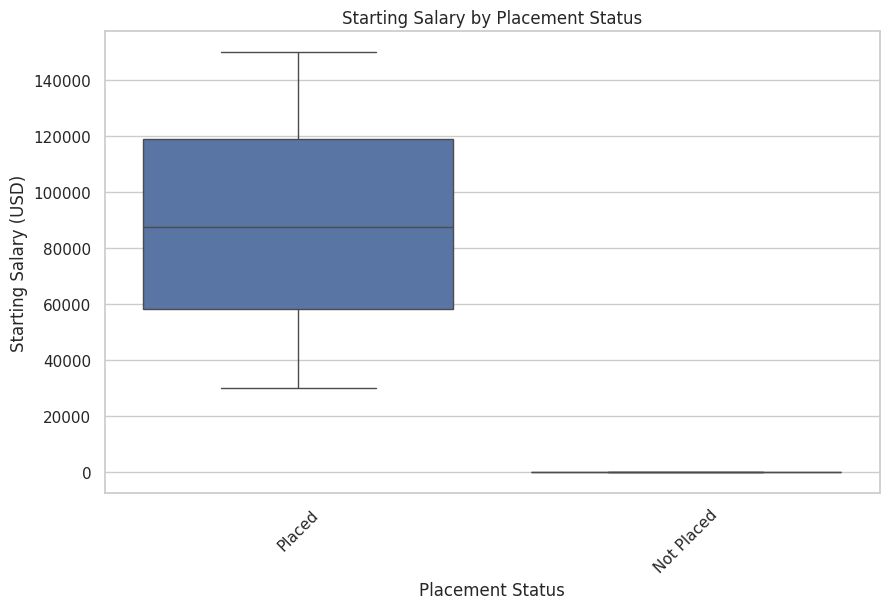

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='year_of_enrollment', kde=True, bins=20)
plt.title('Distribution of Year of Enrollment')
plt.xlabel('Year of Enrollment')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='origin_country', order=df['origin_country'].value_counts().index)
plt.title('Count of Students per Origin Country')
plt.xlabel('Origin Country')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Using multiple numeric columns for correlation heatmap if available
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()
    # Pair plot for numeric features
sns.pairplot(numeric_df)
plt.suptitle('Pair Plot of Numeric Features', y=1.02)
plt.show()

# Box plot of starting salary by placement status (if this relationship is of interest)
plt.figure(figsize=(10, 6))
sns.boxplot(x='placement_status', y='starting_salary_usd', data=df)
plt.title('Starting Salary by Placement Status')
plt.xlabel('Placement Status')
plt.ylabel('Starting Salary (USD)')
plt.xticks(rotation=45)
plt.show()
# Pair plot for numeric features
sns.pairplot(numeric_df)
plt.suptitle('Pair Plot of Numeric Features', y=1.02)
plt.show()

# Box plot of starting salary by placement status (if this relationship is of interest)
plt.figure(figsize=(10, 6))
sns.boxplot(x='placement_status', y='starting_salary_usd', data=df)
plt.title('Starting Salary by Placement Status')
plt.xlabel('Placement Status')
plt.ylabel('Starting Salary (USD)')
plt.xticks(rotation=45)
plt.show()

R^2 Score for the Starting Salary predictor: -0.18580754161568436


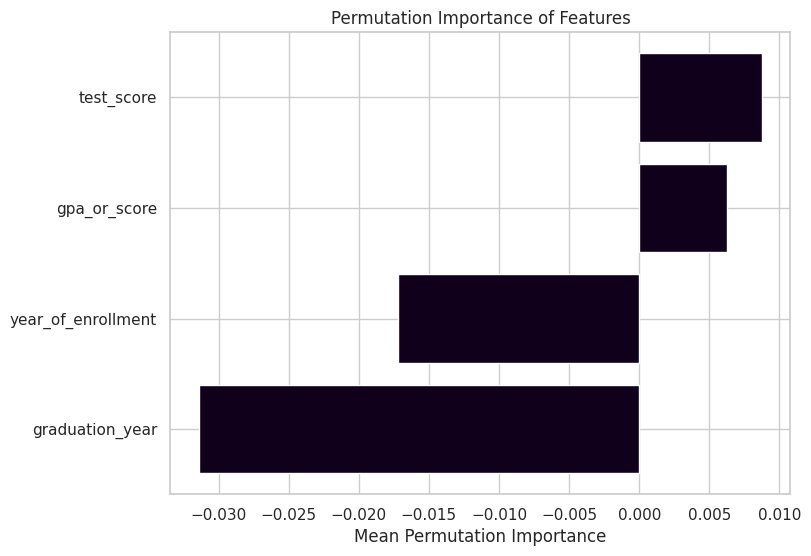

In [6]:
# Predictive Modeling: Forecasting Starting Salary

# We will use the following numeric features for modeling
features = ['year_of_enrollment', 'graduation_year', 'gpa_or_score', 'test_score']
target = 'starting_salary_usd'

# Prepare the data, dropping rows with missing target (if any exist after cleaning)
model_df = df[features + [target]].dropna()

# Split into training and testing sets
X = model_df[features]
y = model_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate model performance using R^2 score
r2 = r2_score(y_test, y_pred)
print('R^2 Score for the Starting Salary predictor:', r2)

# Permutation Importance for feature ranking
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
feature_importance = pd.DataFrame({'feature': features,
                                   'importance': perm_importance.importances_mean})
feature_importance = feature_importance.sort_values(by='importance', ascending=True)

# Plot Permutation Importance
plt.figure(figsize=(8, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='#11001C')
plt.xlabel('Mean Permutation Importance')
plt.title('Permutation Importance of Features')
plt.show()